In [1]:
import numpy as np
from blimpy import read_header, Waterfall, Filterbank

%matplotlib inline
import matplotlib.pyplot as plt

import sys, os, glob
sys.path.append("../../setigen")
import setigen as stg

tsamp = 18.253611008
fch1 = 6095.214842353016
df = -2.7939677238464355e-06

fchans = 1024
tchans = 16

fs = np.arange(fch1, fch1 + fchans*df, df)
ts = np.arange(0, tchans*tsamp, tsamp)

/Users/bbrzycki/anaconda3/envs/breakthroughlisten27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [117]:
# basic cnn training
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 32, 1024

train_data_dir = '../data/set01/train'
validation_data_dir = '../data/set01/validation'
nb_train_samples = 3000
nb_validation_samples = 1200
epochs = 1
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='sparse')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

Found 3002 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.
Epoch 1/1
187/187 [==============================] - 407s 2s/step - loss: 0.9811 - acc: 0.5297 - val_loss: 1.0151 - val_acc: 0.5392


(array([2]), array([[3.5899799e-04, 9.6789527e-01, 9.8576361e-01]], dtype=float32))


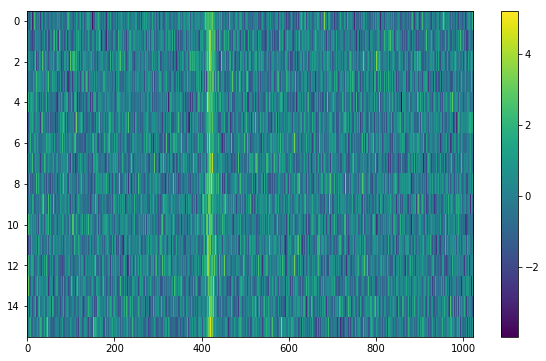

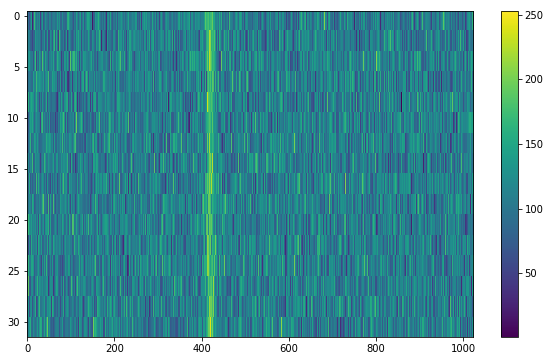

In [120]:
# easier loading? 0.4247

from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import matplotlib.pyplot as plt
from keras.preprocessing import image

# dimensions of our images.
img_width, img_height = 32, 1024

train_data_dir = '../data/set01/train'
validation_data_dir = '../data/set01/validation'
nb_train_samples = 3000
nb_validation_samples = 1200
epochs = 1
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('sigmoid'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.load_weights('first_try.h5')

start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
drift_rate = 0
# level = 0
# if np.random.rand() < 0.3:
level = np.random.uniform(2,5)
amplitude = np.random.uniform(0, max(0, level))

# signal = stg.generate(ts,
#                           fs,
#                           stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
#                           stg.constant_t_profile(level = level),
#                           stg.gaussian_f_profile(width = 0.00002),
#                           stg.constant_bp_profile(level = 1.0))


signal = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                          stg.constant_t_profile(level = level),
                          stg.gaussian_f_profile(width = 0.00002),
                          stg.constant_bp_profile(level = 1.0))

fig = plt.figure(figsize=(10,6))

normalized_signal = stg.inject_noise(signal)

plt.imshow(normalized_signal, aspect='auto')
plt.colorbar()

plt.imsave('interactive.png', normalized_signal)

img = load_img('interactive.png',False,target_size=(32,1024))
x = img_to_array(img)
x = x / 255.
x = np.expand_dims(x, axis=0)
preds = model.predict_classes(x)
prob = model.predict_proba(x)
print(preds, prob)

# fig = plt.figure(figsize=(10,6))
# plt.imshow(normalized_signal, aspect='auto')
# plt.colorbar()
# # plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
# plt.show()

fig = plt.figure(figsize=(10,6))
plt.imshow(img, aspect='auto')
plt.colorbar()
# plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
plt.show()

# fig = plt.figure(figsize=(10,6))
# plt.imshow(img1, aspect='auto')
# plt.colorbar()
# # plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
# plt.show()

# print('32x32: ' % +prob)
# print('256x256: %s; p = %s; level = %s' % (label1, prob1[0][0],level))

In [47]:
y_prob = model.predict(x) 
y_classes = y_prob.argmax(axis=-1)
print(y_prob)
print(y_classes)

[[0.52711326]]
[0]


(array([2]), array([[0., 0., 1.]], dtype=float32))


Actual -- Intensity: 4.279137, drift rate: 0.000000 Hz/s
Predicted -- Zero drift rate


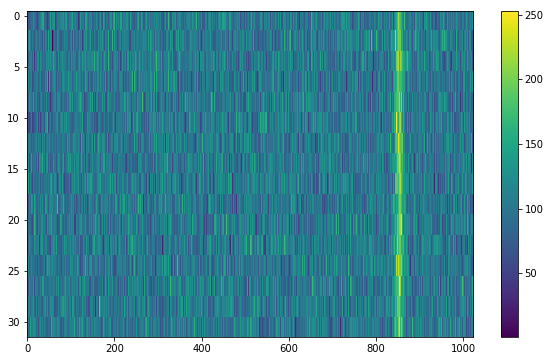

In [171]:
# easier loading? 0.4247

from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import matplotlib.pyplot as plt
from keras.preprocessing import image

# dimensions of our images.
img_width, img_height = 32, 1024

train_data_dir = '../data/set01/train'
validation_data_dir = '../data/set01/validation'
nb_train_samples = 6000
nb_validation_samples = 1500
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.load_weights('../32x1024_multiclass.h5')

start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
level = np.random.uniform(2,5)
x = np.random.rand()
if x < 1/3.:
    level = 0
drift_rate = 0
amplitude = np.random.uniform(0, max(0, level))

signal = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                          stg.constant_t_profile(level = level),
                          stg.gaussian_f_profile(width = 0.00002),
                          stg.constant_bp_profile(level = 1.0))

# fig = plt.figure(figsize=(10,6))

normalized_signal = stg.inject_noise(signal)

# plt.imshow(normalized_signal, aspect='auto')
# plt.colorbar()

plt.imsave('interactive.png', normalized_signal)

img = load_img('interactive.png',False,target_size=(32,1024))
x = img_to_array(img)
x = x / 255.
x = np.expand_dims(x, axis=0)
preds = model.predict_classes(x)
prob = model.predict_proba(x)
print(preds, prob)
print("\n")
print("Actual -- Intensity: %f, drift rate: %f Hz/s" % (level, drift_rate*10**6))
if preds[0] == 0:
    prediction = 'Noise'
elif preds[0] == 1:
    prediction = 'Non-zero drift rate'
else:
    prediction = 'Zero drift rate'
print("Predicted -- %s" % prediction)

fig = plt.figure(figsize=(10,6))
plt.imshow(img, aspect='auto')
plt.colorbar()
# plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
plt.show()


(array([0]), array([[7.8603375e-01, 4.5190876e-07, 1.6187412e-04, 2.1379320e-01,
        1.0703752e-05]], dtype=float32))


Actual -- Intensity: 0.542242, drift rate: -5.175416 Hz/s
Predicted -- Constant nonzero


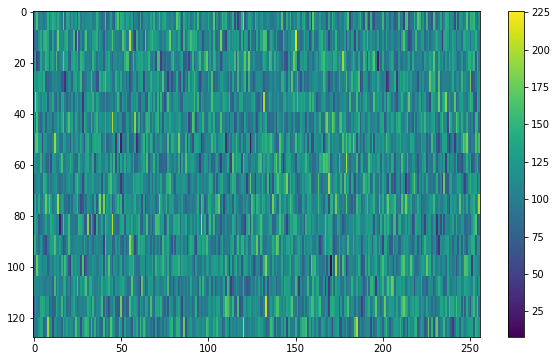

In [6]:
# easier loading? 0.4247

from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import matplotlib.pyplot as plt
from keras.preprocessing import image

# dimensions of our images.
img_width, img_height = 512/4, 1024/4

train_data_dir = 'data/set02/train'
validation_data_dir = 'data/set02/validation'
nb_train_samples = 2000*5
nb_validation_samples = 500*5
epochs = 50
batch_size = 8

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.load_weights('../512x1024_pulsed_multiclass_dim.h5')

start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
#drift_rate = 0
level = np.random.uniform(0.5,5)
period = np.random.uniform(2,4)
phase = np.random.uniform(0,period)
sigma = np.random.uniform(0.1, 2)
pulse_dir = 'rand'
width = np.random.uniform(np.random.uniform(0.1,2))
pnum = 10
amplitude = np.random.uniform(min(1, level/2.), level)

signal = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                          stg.periodic_gaussian_t_profile(period, phase, sigma, pulse_dir, width, pnum, amplitude, level),
                          stg.gaussian_f_profile(width = 0.00002),
                          stg.constant_bp_profile(level = 1.0),
                          integrate = True)

#         normalized_signal = stg.normalize(stg.inject_noise(signal))
normalized_signal = (stg.inject_noise(signal))

# plt.imshow(normalized_signal, aspect='auto')
# plt.colorbar()

plt.imsave('interactive.png', normalized_signal)

img = load_img('interactive.png',False,target_size=(img_width,img_height))
x = img_to_array(img)
x = x / 255.
x = np.expand_dims(x, axis=0)
preds = model.predict_classes(x)
prob = model.predict_proba(x)
print(preds, prob)
print("\n")
print("Actual -- Intensity: %f, drift rate: %f Hz/s" % (level, drift_rate*10**6))
if preds[0] == 0:
    prediction = 'Constant nonzero'
elif preds[0] == 1:
    prediction = 'Constant zero'
elif preds[0] == 2:
    prediction = 'Noise'
elif preds[0] == 3:
    prediction = 'Pulsed nonzero'
else:
    prediction = 'Pulsed zero'
print("Predicted -- %s" % prediction)

fig = plt.figure(figsize=(10,6))
plt.imshow(img, aspect='auto')
plt.colorbar()
# plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
plt.show()


In [120]:
# easier loading?

from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

import matplotlib.pyplot as plt
from keras.preprocessing import image

# dimensions of our images.
img_width, img_height = 128, 128

train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.load_weights('../128x128.h5')

# img = load_img('test.png',False,target_size=(128,128))
# x = img_to_array(img)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# preds = model.predict_classes(x)
# prob = model.predict_proba(x)
# print(preds, prob)

# img = load_img('test_none.png',False,target_size=(128,128))
# x = img_to_array(img)
# x = x / 255.
# x = np.expand_dims(x, axis=0)
# preds = model.predict_classes(x)
# prob = model.predict_proba(x)
# print(preds, prob)


In [121]:
# dimensions of our images.
img_width1, img_height1 = 256, 256

train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape1 = (3, img_width1, img_height1)
else:
    input_shape1 = (img_width1, img_height1, 3)

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=input_shape1))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model1.load_weights('../256x256.h5')

In [20]:
prob[0][0]

0.30725452

(array([[0.9794024]], dtype=float32), array([[0.9999236]], dtype=float32))


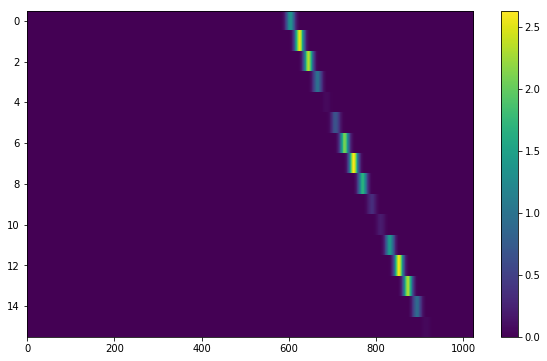

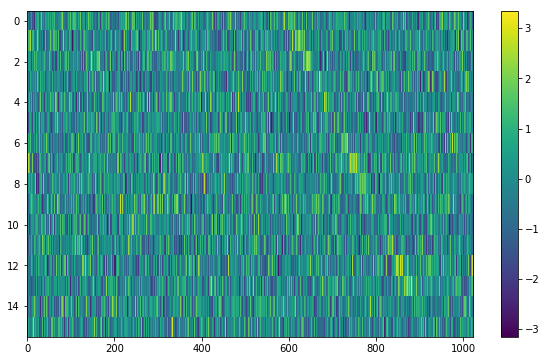

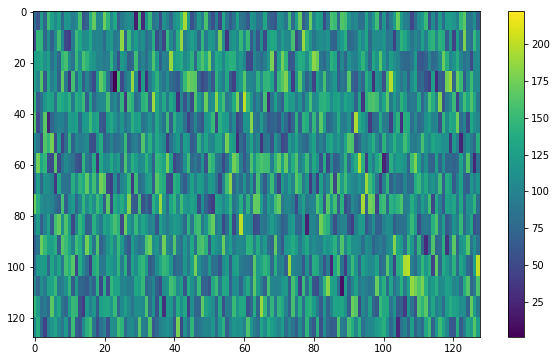

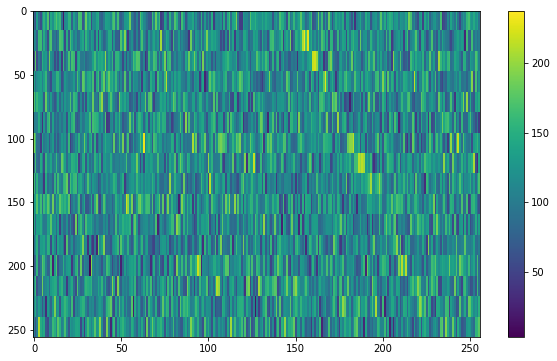

128x128: TRUE; p = 0.9794024; level = 1.35418799575
256x256: TRUE; p = 0.9999236; level = 1.35418799575


In [171]:
start_index = np.random.randint(0,fchans)
drift_rate = np.random.uniform(-start_index*df/(tsamp*tchans),
                               (fchans-1-start_index)*df/(tsamp*tchans))
#drift_rate = 0
level = 0
if np.random.rand() < 0.3:
    level = np.random.uniform(1,3)
amplitude = np.random.uniform(0, max(0, level))

# signal = stg.generate(ts,
#                           fs,
#                           stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
#                           stg.constant_t_profile(level = level),
#                           stg.gaussian_f_profile(width = 0.00002),
#                           stg.constant_bp_profile(level = 1.0))


signal = stg.generate(ts,
                          fs,
                          stg.constant_path(f_start = fs[start_index], drift_rate = drift_rate),
                          stg.sine_t_profile(period = 100, amplitude = amplitude, level = level),
                          stg.gaussian_f_profile(width = 0.00002),
                          stg.constant_bp_profile(level = 1.0))

fig = plt.figure(figsize=(10,6))
plt.imshow(signal, aspect='auto')
plt.colorbar()

normalized_signal = stg.normalize(stg.inject_noise(signal), cols = 0, exclude = 0.0, use_median=False)

plt.imsave('interactive.png', normalized_signal)

img = load_img('interactive.png',False,target_size=(128,128))
x = img_to_array(img)
x = x / 255.
x = np.expand_dims(x, axis=0)
preds = model.predict_classes(x)
prob = model.predict_proba(x)

img1 = load_img('interactive.png',False,target_size=(256,256))
x1 = img_to_array(img1)
x1 = x1 / 255.
x1 = np.expand_dims(x1, axis=0)
preds1 = model1.predict_classes(x1)
prob1 = model1.predict_proba(x1)
print(prob, prob1)

label = 'TRUE'
if preds[0][0] == 0:
    label = 'FALSE'
label1 = 'TRUE'
if preds1[0][0] == 0:
    label1 = 'FALSE'

fig = plt.figure(figsize=(10,6))
plt.imshow(normalized_signal, aspect='auto')
plt.colorbar()
# plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
plt.show()

fig = plt.figure(figsize=(10,6))
plt.imshow(img, aspect='auto')
plt.colorbar()
# plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
plt.show()

fig = plt.figure(figsize=(10,6))
plt.imshow(img1, aspect='auto')
plt.colorbar()
# plt.title('%s; p = %s; level = %s' % (label, prob[0][0],level))
plt.show()

print('128x128: %s; p = %s; level = %s' % (label, prob[0][0],level))
print('256x256: %s; p = %s; level = %s' % (label1, prob1[0][0],level))

In [140]:
np.random.rand()

0.6360554094136684